In [12]:
import random
from pathlib import Path
from typing import Callable, List, Optional, Union, Sequence
import matplotlib
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from torch import nn, optim
from pytorch_lightning.metrics.functional import accuracy
from sklearn.metrics import confusion_matrix
from sunpy.net.vso import VSOQueryResponseTable
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

from solarnet.utils.physics import id_to_class, flux_to_binary_class
from solarnet.utils.plots import plot_confusion_matrix, plot_image_grid

import boto3
from tqdm import tqdm
from solarnet.utils.yaml import load_yaml

import pl_bolts as B
from pl_bolts.models.self_supervised import SimCLR
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.models.self_supervised.simclr.transforms import (
    SimCLREvalDataTransform, SimCLRTrainDataTransform)

import math
import torchvision.transforms.functional as transforms_functional
from solarnet.data.dataset_utils import BaseDataset
from pl_bolts.transforms.self_supervised import Patchify, RandomTranslateWithReflect

In [2]:
from typing import Optional, Sequence, Tuple, Union

import torch
from pytorch_lightning import Callback, LightningModule, Trainer
from torch import device, Tensor
from torch.nn import functional as F
from torch.optim import Optimizer
from torchmetrics.functional import accuracy

def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

class SSLOnlineEvaluator(Callback):  # pragma: no cover
    """
    Attaches a MLP for fine-tuning using the standard self-supervised protocol.

    Example::

        # your model must have 2 attributes
        model = Model()
        model.z_dim = ... # the representation dim
        model.num_classes = ... # the num of classes in the model

        online_eval = SSLOnlineEvaluator(
            z_dim=model.z_dim,
            num_classes=model.num_classes,
            dataset='imagenet'
        )

    """

    def __init__(
            self,
            dataset: str,
            drop_p: float = 0.2,
            hidden_dim: Optional[int] = None,
            z_dim: int = None,
            num_classes: int = None,
            learning_rate: float = 1e-4,
    ):
        """
        Args:
            dataset: if stl10, need to get the labeled batch
            drop_p: Dropout probability
            hidden_dim: Hidden dimension for the fine-tune MLP
            z_dim: Representation dimension
            num_classes: Number of classes
        """
        super().__init__()

        self.hidden_dim = hidden_dim
        self.drop_p = drop_p
        self.optimizer: Optimizer
        self.learning_rate = learning_rate

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.dataset = dataset

    def on_pretrain_routine_start(self, trainer: Trainer, pl_module: LightningModule) -> None:
        from pl_bolts.models.self_supervised.evaluator import SSLEvaluator

        pl_module.non_linear_evaluator = SSLEvaluator(
            n_input=self.z_dim,
            n_classes=self.num_classes,
            p=self.drop_p,
            n_hidden=self.hidden_dim,
        ).to(pl_module.device)

        pl_module.non_linear_evaluator.apply(weight_init)

        self.optimizer = torch.optim.Adam(pl_module.non_linear_evaluator.parameters(), lr=self.learning_rate)

    def get_representations(self, pl_module: LightningModule, x: Tensor) -> Tensor:
        representations = pl_module(x)
        representations = representations.reshape(representations.size(0), -1)
        return representations

    def to_device(self, batch: Sequence, device: Union[str, device]) -> Tuple[Tensor, Tensor]:
        # get the labeled batch
        if self.dataset == 'stl10':
            labeled_batch = batch[1]
            batch = labeled_batch

        inputs, y = batch

        # last input is for online eval
        x = inputs[-1]
        x = x.to(device)
        y = y.to(device)

        return x, y

    def on_train_batch_end(
            self,
            trainer: Trainer,
            pl_module: LightningModule,
            outputs: Sequence,
            batch: Sequence,
            batch_idx: int,
            dataloader_idx: int,
    ) -> None:
        if trainer.current_epoch > 3:
            
            x, y = self.to_device(batch, pl_module.device)

            with torch.no_grad():
                representations = self.get_representations(pl_module, x)

            representations = representations.detach()

            # forward pass
            mlp_preds = pl_module.non_linear_evaluator(representations)  # type: ignore[operator]
            mlp_loss = F.cross_entropy(mlp_preds, y, weight=torch.tensor([0.8782, 1.1610], dtype=float, device=pl_module.device).float())

            # update finetune weights
            mlp_loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            # log metrics
            train_acc = accuracy(mlp_preds, y)
            pl_module.log('online_train_acc', train_acc, on_step=True, on_epoch=False)
            pl_module.log('online_train_loss', mlp_loss, on_step=True, on_epoch=False)

    def on_validation_batch_end(
            self,
            trainer: Trainer,
            pl_module: LightningModule,
            outputs: Sequence,
            batch: Sequence,
            batch_idx: int,
            dataloader_idx: int,
    ) -> None:
        if trainer.current_epoch > 3:
            x, y = self.to_device(batch, pl_module.device)

            with torch.no_grad():
                representations = self.get_representations(pl_module, x)

            representations = representations.detach()

            # forward pass
            mlp_preds = pl_module.non_linear_evaluator(representations)  # type: ignore[operator]
            mlp_loss = F.cross_entropy(mlp_preds, y)

            # log metrics
            val_acc = accuracy(mlp_preds, y)
            pl_module.log('online_val_acc', val_acc, on_step=False, on_epoch=True, sync_dist=True)
            pl_module.log('online_val_loss', mlp_loss, on_step=False, on_epoch=True, sync_dist=True)


In [3]:

CHANNEL_PREPROCESS = {
    "171": {"min": 5, "max": 3500, "scaling": "log10"},
    "Bz": {"min": -250, "max": 250, "scaling": None},
}


def get_sdo_transform(channel: Union[str, int]):
    preprocess_config = CHANNEL_PREPROCESS[str(channel)]

    lambda_transform = lambda x: torch.clamp(
        transforms_functional.vflip(x),
        min=preprocess_config["min"],
        max=preprocess_config["max"],
    )

    mean = preprocess_config["min"]
    std = preprocess_config["max"] - preprocess_config["min"]

    if preprocess_config["scaling"] == "log10":
        base_lambda = lambda_transform
        lambda_transform = lambda x: torch.log10(base_lambda(x))
        mean = math.log10(preprocess_config["min"])
        std = math.log10(preprocess_config["max"]) - math.log10(preprocess_config["min"])

    return transforms.Compose(
        [
            # transforms.Resize(resize),
            # transforms.CenterCrop((resize // 2, resize - resize // 8)),
            transforms.Lambda(lambda_transform),
            transforms.Normalize(mean=[mean], std=[std]),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ]
    )

In [4]:

# augmentations
channel = 171
resize = 512


class SDOSimCLRTrainDataTransform(object):
    def __init__(
            self,
            input_height: int = 64,
            do_online_transform: bool = False,
            transform_before: Optional[Callable] = None,
            transform_after: Optional[Callable] = None,
            prob_random_horizontal_flip: float = 0.5,
            min_scale_resize: float = 0.5,
            max_scale_resize: float = 1.0,
    ) -> None:
        self.input_height = input_height
        self.do_online_transform = do_online_transform
        self.transform_before = transform_before
        self.transform_after = transform_after

        _transforms = [
            transforms.RandomResizedCrop(self.input_height, scale=(min_scale_resize, max_scale_resize)),
            transforms.RandomHorizontalFlip(prob_random_horizontal_flip),
        ]
        _online_transforms = [transforms.Resize(input_height)]

        if transform_before is not None:
            _transforms.insert(0, transform_before)
            _online_transforms.insert(0, transform_before)
        if transform_after is not None:
            _transforms.append(transform_after)
            _online_transforms.append(transform_after)

        self.train_transform = transforms.Compose(_transforms)

        self.online_transform = transforms.Compose(_online_transforms)

    def __call__(self, sample):
        xi = self.train_transform(sample)
        xj = self.train_transform(sample)

        if self.do_online_transform:
            return xi, xj, self.online_transform(sample)
        return xi, xj


transform_before = transforms.Compose([
    transforms.Resize(resize),
    transforms.CenterCrop((resize // 2, resize - resize // 8)),
])

train_transform = SDOSimCLRTrainDataTransform(
    128,
    do_online_transform=True,
    transform_before=transform_before,
    transform_after=get_sdo_transform(channel),
)
eval_transform = SDOSimCLRTrainDataTransform(
    128,
    do_online_transform=True,
    transform_before=transform_before,
    transform_after=get_sdo_transform(channel),
)


In [5]:

class SDODatasetSSL(BaseDataset):
    DATETIME_COLUMN = "datetime"
    PATH_COLUMN_PREFIX = "path_"
    TARGET_COLUMN = "peak_flux"

    # N_SEQ = 3

    def __init__(
            self,
            dataset_path: Path,
            dataset_root_path: Path = None,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
    ):
        if dataset_path.is_file():
            self.csv_file = dataset_path
            self.dataset_folder = dataset_path.parent
        else:
            self.csv_file = dataset_path / "sdo-dataset.csv"
            self.dataset_folder = dataset_path

        if dataset_root_path is not None:
            self.dataset_folder = dataset_root_path

        # Properties
        self.transform = transform
        self.target_transform = target_transform

        # Load dataset metadata
        self.dataset = pd.read_csv(self.csv_file, parse_dates=[self.DATETIME_COLUMN])

        if len(self.dataset) == 0:
            raise RuntimeError(f"Dataset in {self.csv_file} is empty.")

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, index):
        # Get a sample from the dataset metadata
        sample: pd.Series = self.dataset.iloc[index]

        # Get the target
        target = int(sample[self.TARGET_COLUMN] > 1e-7)

        # Get the paths to images
        paths = sample.filter(like=self.PATH_COLUMN_PREFIX, axis=0).values

        # Load a numpy array from .npz and convert to pytorch tensor, for each image
        tensors = [torch.from_numpy(np.load(self.dataset_folder / path)["x"]) for path in paths]

        # Stack tensors (images) together to make a multi-dim tensor (like an image with several channels)
        tensor = torch.stack(tensors)

        # Transform the data and target
        if self.transform:
            tensor = self.transform(tensor)
        if self.target_transform:
            target = self.target_transform(target)

        return tensor, target

    def y(self, indices: Optional[Sequence[int]] = None) -> list:
        if indices is None:
            targets = self.dataset[self.TARGET_COLUMN].tolist()
        else:
            targets = self.dataset.iloc[indices][self.TARGET_COLUMN].tolist()

        if self.target_transform is not None:
            targets = list(map(self.target_transform, targets))

        return targets


class SDODatasetSSLDataModule(pl.LightningDataModule):
    def __init__(
            self,
            dataset_path: Path,
            csv_filename_prefix: str = "sdo-dataset",
            # channel: Union[str, int] = 171,
            batch_size: int = 32,
            num_workers: int = 0,
            # resize: int = 512,
            train_transform: Optional[Callable] = None,
            eval_transform: Optional[Callable] = None,
    ):

        super().__init__()
        self.dataset_path = dataset_path
        self.csv_filename_prefix = csv_filename_prefix
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.eval_transform = eval_transform

        # transform_list = [get_sdo_transform(channel, resize)]
        # if transform is not None:
        #     transform_list.append(transform)
        # self.transform = transforms.Compose(transform_list)

    @property
    def num_samples(self) -> int:
        return len(self.dataset_train)

    def prepare_data(self):
        pass

    def setup(self, stage: Optional[str] = None):
        if stage == 'fit' or stage is None:
            self.dataset_train = SDODatasetSSL(
                self.dataset_path / f"{self.csv_filename_prefix}-train.csv",
                transform=self.train_transform,
            )
            self.dataset_val = SDODatasetSSL(
                self.dataset_path / f"{self.csv_filename_prefix}-val.csv",
                transform=self.eval_transform,
            )
            self.dims = tuple(self.dataset_train[0][0][0].shape)

        if stage == 'test' or stage is None:
            self.dataset_test = SDODatasetSSL(
                self.dataset_path / f"{self.csv_filename_prefix}-test.csv",
                transform=self.eval_transform,
            )
            self.dims = tuple(self.dataset_test[0][0][0].shape)

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, num_workers=self.num_workers)


dm = SDODatasetSSLDataModule(
    Path("../data/sdo-dataset-ssl-171-1h-1"),
    # channel=171,
    batch_size=768,
    # resize=512,
    train_transform=train_transform,
    eval_transform=eval_transform,
    num_workers=20,
)
dm.setup()


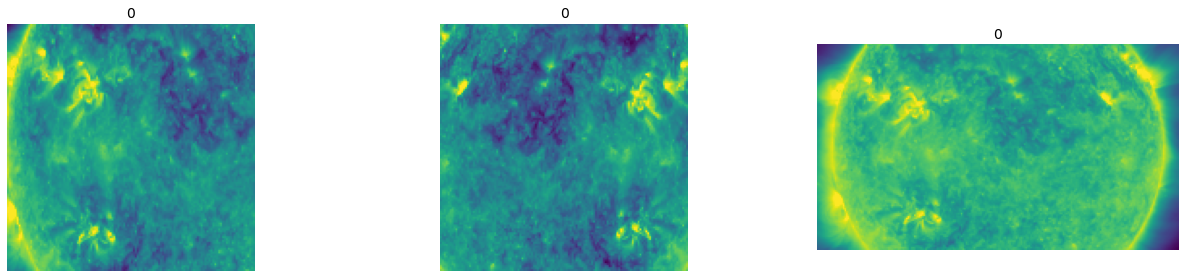

In [24]:
sample_id = 1000
img_data_id = 0

samples = [i[0] for i in dm.dataset_train[sample_id][img_data_id]]

plot_image_grid(samples, [0,0,0], columns=3, height=10)

In [7]:
# dm = CIFAR10DataModule(num_workers=0)
# dm.train_transforms = SimCLRTrainDataTransform(32)
# dm.val_transforms = SimCLREvalDataTransform(32)

model = SimCLR(num_samples=dm.num_samples, batch_size=dm.batch_size, dataset='sdo-dataset', gpus=2,
               arch="resnet50", hidden_mlp = 2048, feat_dim = 64,)
model.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

online_finetuner = SSLOnlineEvaluator(
    "sdo-dataset",
    hidden_dim=128,
    z_dim=model.hidden_mlp,
    num_classes=2,
    learning_rate=1e-5,
)

trainer = pl.Trainer(
    max_epochs=60,
    gpus=2,
    accelerator="dp",
    callbacks=[online_finetuner],
    num_sanity_val_steps=0,
    )
trainer.fit(model, datamodule=dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-2-791574abac33>:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)

  | Name                 | Type         | Params
------------------------------------------------------
0 | encoder              | ResNet       | 25.6 M
1 | projection           | Projection   | 4.3 M 
2 | non_linear_evaluator | SSLEvaluator | 262 K 
------------------------------------------------------
30.1 M    Trainable params
0         Non-trainable params
30.1 M    Total params
120.580   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/jonathan.donzallaz/anaconda3/envs/solarnet-conda-env/lib/python3.8/site-packages/pytorch_lightning/core/step_result.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/jonathan.donzallaz/anaconda3/envs/solarnet-conda-env/lib/python3.8/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [8]:
model

SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [9]:
# t = dm.dataset_train[0][0][0]
# t3=torch.cat(3*[t])
# t.shape

In [10]:
# model.encoder(t.unsqueeze(0).to("cuda"))[0].shape